# Automated Evaluation for KWS Under Different Noise Scenarios


Using this notebook, you can test different SNR levels and different noise kinds to test previously trained KWS models. You need trained models checkpoint file, a specified SNR level and specified noise kind list. Notebook uses signalmixer data loader to mix the KWS and specified noise data and creates a mixed dataset using the specified SNR level. Notebook do the evaluation on these mixed datasets and creates comparison plots for different type of models.

In [1]:
###################################################################################################
#
# Copyright (C) 2022-2023 Maxim Integrated Products, Inc. All Rights Reserved.
#
# Maxim Integrated Products, Inc. Default Copyright Notice:
# https://www.maximintegrated.com/en/aboutus/legal/copyrights.html
#
###################################################################################################

import os
import sys

import numpy as np
import torch
import pandas as pd
import matplotlib.pyplot as plt

import torchnet.meter as tnt
from collections import OrderedDict
import importlib
from torchvision import transforms

sys.path.append(os.path.join(os.getcwd(), '..'))
sys.path.append(os.path.join(os.getcwd(), '../models/'))
sys.path.append(os.path.join(os.getcwd(), '../datasets/'))

from types import SimpleNamespace

import ai8x

import msnoise
from signalmixer import signalmixer

## Step 1: Initialize and load the model

You need to set the checkpoint path and the model name accordingly. 

In [2]:
trained_checkpoint_path = os.path.join("/home/merveeyuboglu/Github/ai8x-training/codes/checkpoints/TrueVAL_NAS_0911Speed_DynAug/","qat_best.pth.tar")
mod = importlib.import_module("ai85nasnet_kws20_res_1")
model_file = "ai85nasnet_kws20_res_1"

In [3]:
dataset = importlib.import_module("kws20")

classes = ['up', 'down', 'left', 'right', 'stop', 'go', 'yes', 'no', 'on', 'off', 'one',
           'two', 'three', 'four', 'five', 'six', 'seven', 'eight', 'nine', 'zero', 'unknown']

device = torch.device('cuda' if torch.cuda.is_available() else 'cpu')
print("Working with device:", device)

ai8x.set_device(device=85, simulate=False, round_avg=False)
qat_policy = {'start_epoch': 10, 'weight_bits': 8, 'bias_bits': 8}

Working with device: cuda
Configuring device: MAX78000, simulate=False.


In [4]:
model = mod.AI85NASNET_KWS20_RES_1(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=True, 
                           quantize_activation=False)


In [5]:
checkpoint = torch.load(trained_checkpoint_path)

state_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('module.'):
        k = k[7:]
    new_state_dict[k] = v
checkpoint['state_dict'] = new_state_dict

ai8x.fuse_bn_layers(model)
ai8x.initiate_qat(model, qat_policy)
model.load_state_dict(checkpoint['state_dict'], strict=False)

ai8x.update_model(model)

## Step 2: Setting up the Test Set and Parameters

You need to load the KWS test set and specify a noise list and snr level list. 

 If you want to specify noise kinds, you should be selecting from the defined classes for MSnoise dataset.

In [6]:
sn = SimpleNamespace()
sn.truncate_testset = False
sn.act_mode_8bit = False

_, test_dataset = dataset.KWS_20_get_datasets( ('/data_ssd/', sn), load_train=False, load_test=True)

originals = list(range(0, len(test_dataset), 3))
test_dataset.data = test_dataset.data[originals]
test_dataset.targets = test_dataset.targets[originals]

No key `stretch` in input augmentation dictionary! Using defaults: [Min: 0.8, Max: 1.3]

Processing test...
test set: 33015 elements
Class up (# 31): 1275 elements
Class down (# 5): 1218 elements
Class left (# 15): 1236 elements
Class right (# 23): 1188 elements
Class stop (# 27): 1233 elements
Class go (# 11): 1206 elements
Class yes (# 34): 1257 elements
Class no (# 19): 1215 elements
Class on (# 21): 1188 elements
Class off (# 20): 1206 elements
Class one (# 22): 1197 elements
Class two (# 30): 1272 elements
Class three (# 28): 1215 elements
Class four (# 10): 1200 elements
Class five (# 7): 1335 elements
Class six (# 26): 1182 elements
Class seven (# 24): 1218 elements
Class eight (# 6): 1224 elements
Class nine (# 18): 1224 elements
Class zero (# 35): 1254 elements
Class UNKNOWN: 8472 elements


Noise_list and snr_list can be changed as wanted.

In [7]:
noise_list = ['AirConditioner',
            'AirportAnnouncements',
            'Babble',
            'CopyMachine',
            'Munching',
            'NeighborSpeaking',
            'ShuttingDoor',
            'Typing',
            'VacuumCleaner',
            'TradeShow',
            'WhiteNoise']

In [8]:
snr_list = [-5, 0, 5, 10, 15, 20]

## Step 3: Functions to Evaluate Different SNR Levels

Using the evaluate, snr_testing and benchmark functions, you can test different SNR levels on your trained models evaluation. You can change the parameters above and test the wanted parameteres using these functions.

In [9]:
def calculate_snr_num(snr_list):
    snr_num = len(snr_list)
    return snr_num

- Evaluate function takes the specified SNR level and Noise kind and apply it to the KWS test set.
- Snr_testing function takes the SNR list and specified noise kind and uses evaluate function to make evaluation on the KWS test set.
- Benchmark function takes SNR List and Noise Kind list and for each noise kind, makes evaluation for each SNR level in the SNR list.

In [10]:
def evaluate(db = None, noise = False, noise_kind = None):

    if (noise == True) and (noise_kind == None):
        print('Noise kind is not specified. Noise will not be applied.')
        noise = False

    model.eval()
    model.to(device) 
    classerr = tnt.ClassErrorMeter(accuracy=True, topk=(1, min(len(classes), 5)))

    transform = transforms.Compose([
        ai8x.normalize(args=sn)
    ])
    
    if noise:
        if (noise_kind == 'WhiteNoise'):

            mixed_signals = signalmixer(test_dataset, snr = db, noise_kind = noise_kind, noise_dataset = None)
            mixed_signals_loader = torch.utils.data.DataLoader(mixed_signals, batch_size = 256)

        else:
            noise_dataset = msnoise.MSnoise(root = '/data_ssd', classes = [noise_kind], d_type = 'test', len = 11005, remove_unknowns=True,
                                        transform=None, quantize=False, download=False)

            mixed_signals = signalmixer(test_dataset, snr = db, noise_kind = noise_kind, noise_dataset = noise_dataset)
            mixed_signals_loader = torch.utils.data.DataLoader(mixed_signals, batch_size = 256)
    else:
        mixed_signals_loader = torch.utils.data.DataLoader(test_dataset, batch_size = 256)
        
    with torch.no_grad():
        for batch_idx, (inputs, targets) in enumerate(mixed_signals_loader):
            # you can use the next line to create audio files for mixed samples
            #write(f'/home/merveeyuboglu/Github/ai8x-training/codes/audios/{noise_kind}_{db}.wav', 16384, np.array(inputs[0]).flatten('F'))
            inputs = inputs.to(device)
            targets = targets.to(device)
            outputs = model(inputs)
            classerr.add(outputs, targets)

            print("Batch: [",batch_idx*256 ,"/", len(test_dataset),"]")
            acc = classerr.value()[0]
            print("Accuracy: ", acc)
            
    print("Total Accuracy: ", acc)
    return acc

In [11]:
def snr_testing(snr_list = None, noise_kind = None, noise = False):

    # raw test set evaluation
    if noise == False:
        db = None
        noise_kind = None
        accuracies = np.zeros(1)
        accuracies[0] = evaluate(db, noise, noise_kind)

    # noisy test set evaluation
    else:
        snr_num = calculate_snr_num(snr_list)
        accuracies = np.zeros(snr_num)

        for idx, db in enumerate(snr_list):
            print("Evaluating SNR levels of", db)
            accuracies[idx] = evaluate(db, noise, noise_kind)

    return accuracies

In [12]:
def benchmark(noise_list = None, snr_list = None):

    if noise_list == None:
        print('Noise kind is not specified. Noise will not be applied.')
        noise = False
        snr_list = None
    else:
        noise = True
        if snr_list == None:
            print('Using default values for SNR levels: [-5, 20] dB.')
            snr_list = range(-5, 20)

    if noise:

        snr_num = calculate_snr_num(snr_list)
        num = len(noise_list) + 1

        accuracies = np.zeros((num, snr_num))

        for idx, n in enumerate(noise_list):
            print(f'{n} Noise Evaluation')
            accuracies[idx] = snr_testing(snr_list, noise_kind = n, noise = noise)

    accuracies[-1] = snr_testing(noise = False)

    return accuracies  

In [ ]:
accuracies_nas = benchmark(noise_list = noise_list, snr_list = snr_list)

In [14]:
accuracies = [accuracies_nas]

### Optional Step

You can create multiple accuracies using different models and afterwards you can create plots for all of them.

- v3 Model

In [ ]:
trained_checkpoint_path = os.path.join("/home/merveeyuboglu/Github/ai8x-training/codes/checkpoints/TrueVAL_v3_0911Speed_DynAug","qat_best.pth.tar")              
mod = importlib.import_module("ai85net-kws20-v3")
model_file = "ai85net-kws20-v3"

checkpoint = torch.load(trained_checkpoint_path)

model = mod.AI85KWS20Netv3(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=False, 
                           quantize_activation=False)

state_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('module.'):
        k = k[7:]
    new_state_dict[k] = v
checkpoint['state_dict'] = new_state_dict

ai8x.fuse_bn_layers(model)
ai8x.initiate_qat(model, qat_policy)
model.load_state_dict(checkpoint['state_dict'], strict=False)

ai8x.update_model(model)

accuracies_v3 = benchmark(noise_list = noise_list, snr_list = snr_list)

- v2 Model

In [ ]:
trained_checkpoint_path = os.path.join("/home/merveeyuboglu/Github/ai8x-training/codes/checkpoints/TrueVAL_v2_0911Speed_DynAug","qat_best.pth.tar")              
mod = importlib.import_module("ai85net-kws20-v2")
model_file = "ai85net-kws20-v2"

checkpoint = torch.load(trained_checkpoint_path)

model = mod.AI85KWS20Netv2(num_classes=len(classes), num_channels=128, dimensions=(128, 1), bias=False, 
                           quantize_activation=False)

state_dict = checkpoint['state_dict']
new_state_dict = OrderedDict()
for k, v in state_dict.items():
    if k.startswith('module.'):
        k = k[7:]
    new_state_dict[k] = v
checkpoint['state_dict'] = new_state_dict

ai8x.fuse_bn_layers(model)
ai8x.initiate_qat(model, qat_policy)
model.load_state_dict(checkpoint['state_dict'], strict=False)

ai8x.update_model(model)

accuracies_v2 = benchmark(noise_list = noise_list, snr_list = snr_list)

In [17]:
accuracies = [accuracies_nas, accuracies_v2, accuracies_v3]
model_files = ["ai85nasnet_kws20_res_1", "ai85net-kws20-v2", "ai85net-kws20-v3"]

## Step 4: Noise Kind Comparison Plots

You can create data frames to examine the results of evaluation. Using the data frame, you can create plots to compare noise kinds for each model.

In [28]:
accs = []
for model_name, model_acc in enumerate(accuracies):
    csv = {}

    for idx, i in enumerate(noise_list):
        csv[i] = model_acc[idx]
            
        csv_list = []
        csv_list.append(['raw', 'None', model_acc[-1][0]])

        for i in csv.keys():
            for idx, j in enumerate(csv[i]):
                csv_list.append([i, snr_list[idx], j])

        df = pd.DataFrame(csv_list, columns = ['Type', 'SNR (dB)', f'{model_files[model_name]}'])
        
    accs.append(df)

for i in accs:
    df[i.columns[-1]] = i[i.columns[-1]]

In [30]:
df

,Type,SNR (dB),ai85net-kws20-v3,ai85nasnet_kws20_res_1,ai85net-kws20-v2
0,raw,None,90.804180,93.766470,92.021808
1,AirConditioner,-5,30.368015,45.706497,35.402090
2,AirConditioner,0,52.112676,68.468878,59.209450
3,AirConditioner,5,69.741027,81.281236,77.401181
4,AirConditioner,10,80.981372,87.705588,85.933667
...,...,...,...,...,...
62,WhiteNoise,0,73.957292,81.926397,79.972740
63,WhiteNoise,5,83.880055,88.741481,86.533394
64,WhiteNoise,10,87.832803,91.422081,89.195820
65,WhiteNoise,15,89.731940,92.576102,90.713312


In [31]:
def plot_values(model_num):

    accuracies_values = {}

    for noise in noise_list:
        acc_list = []
        for idx, i in enumerate(df['Type'].values[1:]): 
            if i == noise:
                acc_list.append(df[model_num][1:][idx+1])
        accuracies_values[noise] = acc_list

    return accuracies_values

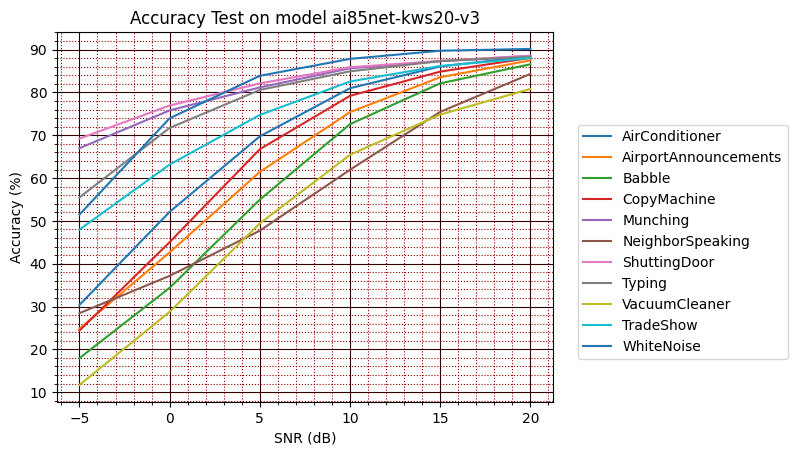

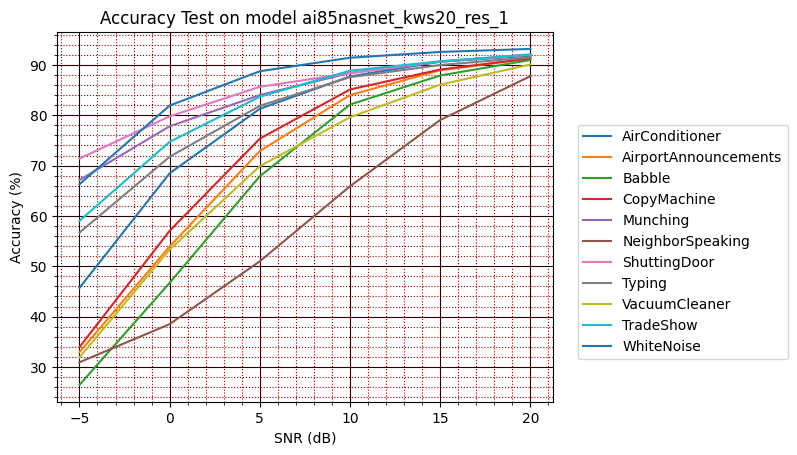

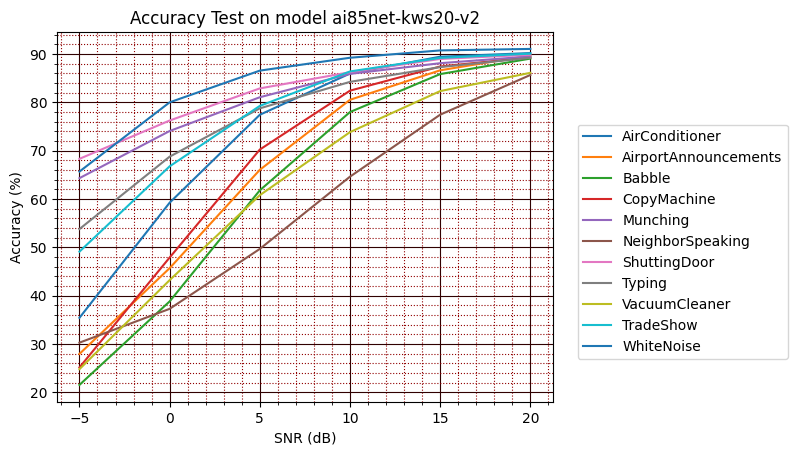

In [32]:
for model_num in df.columns[2:]:
    accuracies_values = plot_values(model_num)
    plt.figure()
    plt.grid(visible=True, which='major', color='#300000', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#900000', linestyle=':')
    for noise in noise_list:
        plt.title(f'Accuracy Test on model {model_num}')
        plt.xlabel('SNR (dB)')
        plt.ylabel('Accuracy (%)')
        plt.plot(snr_list, accuracies_values[noise])

    plt.legend(noise_list, bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)

## Step 5: Model Comparison Plots for Each Noise Kind

You can also see the comparison between each model for each noise kind separately.

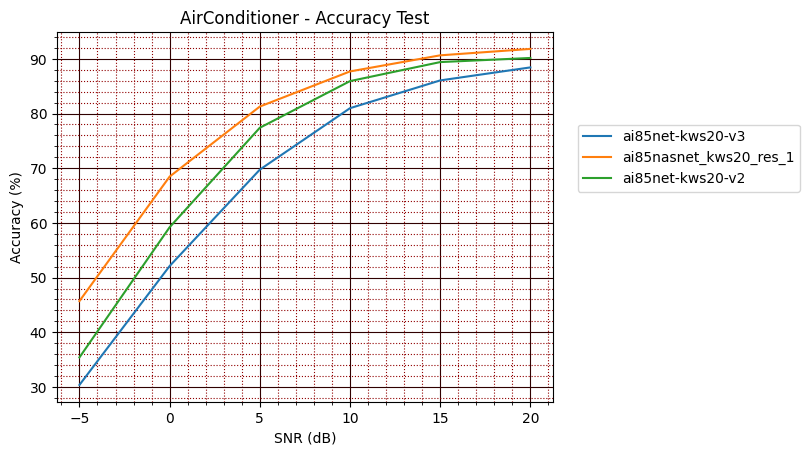

In [27]:
acc_list = []
for model_num in df.columns[2:]:
    acc_list.append(plot_values(model_num))
    
for noise in noise_list:
    plt.figure()
    plt.grid(visible=True, which='major', color='#300000', linestyle='-')
    plt.minorticks_on()
    plt.grid(visible=True, which='minor', color='#900000', linestyle=':')
    plt.title(f'{noise} - Accuracy Test')
    plt.xlabel('SNR (dB)')
    plt.ylabel('Accuracy (%)')
    for model in acc_list:
        plt.plot(snr_list , model[noise])
    plt.legend(df.columns[2:], bbox_to_anchor=(1.05, 0.75),
                        loc='upper left', borderaxespad=0.)
    
    # you can remove the break to see all noise kind comparisons
    break

## Additional Step: CSV Application

You can also create CSV files using the predefined data frames. If the current model file is already in the CSV file, accuracies will not be added to the CSV file. If not, then the current accuracy results will be added to the CSV file as a new column.

- You have to make sure that you test the same noise kinds for same SNR levels for all of the models.

In [25]:
if os.path.exists('/home/merveeyuboglu/Github/ai8x-training/codes/acc.csv'):
    current = pd.read_csv('/home/merveeyuboglu/Github/ai8x-training/codes/acc.csv', decimal=',', sep=';')
    if model_file in current.columns:
        print(f'This model file ({model_file}) already exists!')
    else:
        current[model_file] = list(df[model_file].values)
        current.to_csv('acc.csv', sep=';', decimal=',', index=False)

else:
    df.to_csv('acc.csv', sep=';', decimal=',', index=False)